<a href="https://colab.research.google.com/github/ParthikB/F.R.I.E.N.D.S/blob/master/FRIENDS_siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
PROGRESS LADDER:

            Similarity Score between some person and F.R.I.E.N.D.S. Characters
                                          ^
                  Saved Facial Features Value of all the 6 characters
                                          ^
          A Model that will extract the facial feature information from the image
                                        

'''

'\nPROGRESS LADDER:\n\n            Similarity Score between some person and F.R.I.E.N.D.S. Characters\n                                          ^\n                  Saved Facial Features Value of all the 6 characters\n                                          ^\n          A Model that will extract the facial feature information from the image\n                                        \n\n'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import cv2, os
import random

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')


ROOT = '/content/drive/My Drive/Colab Notebooks/friends'
os.chdir(ROOT)

Running on : GPU


# Building the Dataset

### Load the Dataset if available

In [3]:
os.chdir(ROOT+'/dataset')

# LOAD
dataset = np.load('dataset.npz', allow_pickle=True)['arr_0'].tolist()
print('Length of Dataset :', len(dataset))

Length of Dataset : 3600


### Positive Labels

In [295]:
DIM = 128

positives = []

data_dir = '/dataset/faces/'
os.chdir(ROOT+data_dir)

names = os.listdir()
for name in tqdm(names):
  for i in tqdm(range(1, len(os.listdir(name))+1), leave=False):
    first = cv2.imread(f'{name}/{i}.pgm', 0)
    first = cv2.resize(first, (DIM, DIM))
    # Adding the Batch Dimension
    first = first[None, :, :]

    for j in tqdm(range(i+1, len(os.listdir(name))+1), leave=False):
      second = cv2.imread(f'{name}/{j}.pgm', 0)
      second = cv2.resize(second, (DIM, DIM))

      # Adding the Batch Dimension
      second = second[None, :, :]
    
      features = [torch.Tensor(first), torch.Tensor(second)]

      positives.append([features, torch.Tensor([1]).long()]) # 1 -> Same  

print('Total Positive Examples :', len(positives))


Total Positive Examples : 1800


### Negetive Labels

In [296]:
data_dir = '/dataset/faces/'
os.chdir(ROOT+data_dir)

def generate_negetives():
  negetives = []
  names = os.listdir()
  for name in tqdm(range(1, len(names)+1)):
    fname = f's{name}'
    
    for i in tqdm(range(1, len(os.listdir(fname))+1), leave=False):
      first = plt.imread(f'{fname}/{i}.pgm')
      first = cv2.resize(first, (DIM, DIM))

      # Adding the Batch Dimension
      first = first[None, :, :]
      
      for j in tqdm(range(name+1, len(names)+1), leave=False):
        second_name = f's{name+1}'
      
        for k in tqdm(range(1, len(os.listdir(second_name))+1), leave=False):
          second = plt.imread(f'{second_name}/{k}.pgm')
          second = cv2.resize(second, (DIM, DIM))
          
          # Adding the Batch Dimension
          second = second[None, :, :]
              
          features = [torch.Tensor(first), torch.Tensor(second)]

          negetives.append([features, torch.Tensor([0]).long()]) # 0 -> Not Same  

          if len(negetives) >= len(positives):
            print('Both the Labels got balanced. Terminating now..')
            return negetives

  return negetives

negetives = generate_negetives()
print('Total Negetive Examples :', len(negetives))

Both the Labels got balanced. Terminating now..
Total Negetive Examples : 1800


## Final Dataset

In [4]:
BATCH_SIZE = 16
CLASSES    = 2
TEST_PERCENT = 20


# Concatinating the Labels
# dataset = positives+negetives

# I think it's self-explanatory
random.shuffle(dataset)
print('Length of Final Dataset :', len(dataset))

upto = len(dataset)//TEST_PERCENT

# Splitting the Dataset
train_data = dataset[upto:]
test_data  = dataset[:upto]

# Creating the Dataloader Object
trainSet = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
testSet  = torch.utils.data.DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False)
 
print('Training Samples        :', len(trainSet.dataset))
print('Testing Samples         :', len(testSet.dataset))

Length of Final Dataset : 3600
Training Samples        : 3420
Testing Samples         : 180


### Saving the Dataset

In [299]:
os.chdir(ROOT+'/dataset')

# SAVE
np.savez_compressed('dataset-128.npz', dataset)
print('Dataset Saved.')

Dataset Saved.


### Visualizing a sample

Label : 0


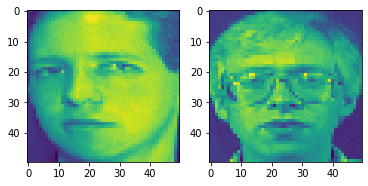

In [5]:
i = np.random.randint(len(trainSet.dataset)) # a random sample from the first batch

img1, img2, y = trainSet.dataset[i][0][0], trainSet.dataset[i][0][1], trainSet.dataset[i][1]

CHANNELS, DIM, DIM = img1.shape
TOTAL_PIXELS = DIM*DIM*CHANNELS

plt.subplot(1, 2, 1)
plt.imshow(img1.view(DIM, DIM)) # Reshaping x from (1, DIM, DIM) --> (DIM, DIM, 1)

plt.subplot(1, 2, 2)
plt.imshow(img2.view(DIM, DIM)) # Reshaping x from (1, DIM, DIM) --> (DIM, DIM, 1)

print('Label :', y.item())

# Defining the Network

In [0]:
class Net(nn.Module):

  def __init__(self):
    super().__init__()

    # Creating the convulutional Layers
    self.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=64, kernel_size=1, stride=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=1)

    self.flatten = None
    # Creating a Random dummy sample to get the Flattened Dimensions
    x = torch.randn(CHANNELS, DIM, DIM).view(-1, CHANNELS, DIM, DIM)
    x = self.convs(x)

    # Creating the Linear Layers
    # print('total', TOTAL_PIXELS)
    self.fc1   = nn.Linear(self.flatten, 256)
    self.fc2   = nn.Linear(256, 2)

  def convs(self, x):
    # Creating the MaxPooling Layers
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    # print(x.shape)

    if not self.flatten:
      self.flatten = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
      # print('flatten', self.flatten)
    return x

  def get_sim_score(self, img1, img2):
    return F.pairwise_distance(img1.view(-1,  1), img2.view(-1,  1), keepdim=True).float()

  
  # FORWARD PASS
  def forward(self, x):

    features = {}
    for img, type_ in zip(x, ['first', 'second']):
      img = img/255.0 # Normalizing
      img = img.to(device)
      img = self.convs(img)
      img = img.view(self.flatten, -1)
      features[type_] = img

    first  = features['first']
    second = features['second']
    
    # CONCATINATION
    # Getting the Euclidian Distance
    edist = self.get_sim_score(first, second)

    edist = edist.view(-1, self.flatten) # self.flatten = 2304
    # print('sm', sm.shape)

    sm = F.relu(self.fc1(edist))
    # print(fc1)
    label = self.fc2(sm)
    # label = F.softmax(self.fc2(sm), dim=1)

    # print(label.shape)

    return label, sm

In [0]:
def train(net, train_set, loss_log=[], EPOCHS=5, LEARNING_RATE=0.001, BATCH_SIZE=32):
  print('Initiating Training..')  
  loss_func = nn.CrossEntropyLoss()

  # Iteration Begins
  for epoch in tqdm(range(EPOCHS)):
    # Iterate over every sample in the batch
    for data in tqdm(trainSet, desc=f'Iteration > {epoch+1}/{EPOCHS} : ', leave=False):
        x, y = data
        net.zero_grad()
        
        #Compute the output
        output, sm = net(x)

        # Compute Train Loss
        loss = loss_func(output, y.squeeze().to(device))
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()


    loss_log.append(loss)
  
  return loss_log



def test(net, test_set, find_accuracy=True):
  print('Initiating Testing..')
  correct = 0
  total   = 0
  accuracy = 0
  sm_log = []
  predictions = []

  with torch.no_grad():
    for data in tqdm(test_set):
      x, y = data

      # Prediction the TestSet Data
      prediction_in_batch, sm = net(x)

      # ARGMAXing the predicted output
      for output in zip(prediction_in_batch, y, sm):
        pred_class, real_class, sm = output
        pred_class = torch.argmax(pred_class)
        sm_log.append([sm, real_class])
        predictions.append(pred_class.item())
        if find_accuracy:
          total += 1
          if real_class == pred_class:
            correct += 1

  if find_accuracy:
    accuracy = (correct/total)*100
    print()
    print(f'Test Accuracy : {round(accuracy, 2)} %')
  
  return accuracy, sm_log, predictions

# Training

Initiating Training..



Initiating Testing..




Test Accuracy : 100.0 %
Total Epochs : 5


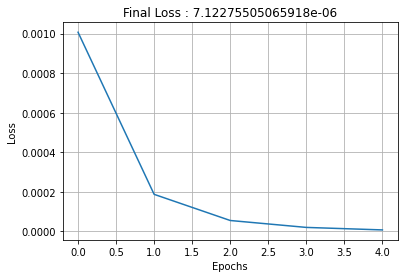

In [8]:
EPOCHS        = 5
LEARNING_RATE = 0.0001
BATCH_SIZE    = BATCH_SIZE
CONTINUE_TRAINING = 0

if not CONTINUE_TRAINING:
  net = Net().to(device)
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []
  total_epochs = 0


total_epochs += EPOCHS
loss_log = train(net, trainSet, loss_log, EPOCHS, LEARNING_RATE, BATCH_SIZE)

plt.plot(loss_log)
plt.grid(1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Final Loss : {loss_log[-1]}')

accuracy, sm_log, preds = test(net, testSet)

print(f'Total Epochs : {total_epochs}')

## Saving the model

In [0]:
torch.save(net, 'model-128')

## Visualizing

Initiating Testing..




Test Accuracy : 100.0 %
Threshold = 654.3469543457031


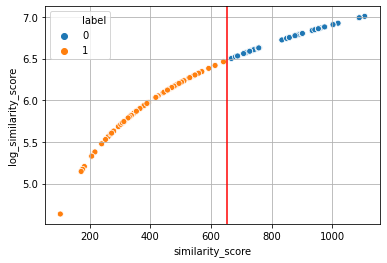

In [10]:
import pandas as pd
import seaborn as sns

accuracy, sm_log, preds = test(net, testSet)
sim_score = [sum(i[0].cpu()).item() for i in sm_log]
label     = [i[1].cpu().item() for i in sm_log]

log = []
for i in range(len(sm_log)):
  log.append([label[i], sim_score[i], np.log(sim_score[i])])
df = pd.DataFrame(log, columns=['label', 'similarity_score', 'log_similarity_score'])

upper_bound = np.min(df[df['label']==0].similarity_score)
lower_bound = np.max(df[df['label']==1].similarity_score)

threshold = (lower_bound+upper_bound)/2
print('Threshold =', threshold)

sns.scatterplot(data=df, x='similarity_score', y='log_similarity_score', hue='label')
plt.axvline(x=threshold, color='red', label='threshold')
plt.grid(1)

We can see that the two labels can easily be seperated linearily. That means, our model is working fine.

# F.R.I.E.N.D.S.

Now, we'll find the similarity score between two FRIENDS's characters and see if they are the same character or not.

If sim_score < threshold --> Same Character

If sim_score > threshold --> Different Characters

In [0]:
import torchvision.models as models
import urllib, numpy as np, cv2
from google.colab.patches import cv2_imshow

def extract_face(img):
  os.chdir(ROOT)

  PAD = 5
  face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_cascade.detectMultiScale(gray)

  if faces is None:
    return print('Face not Detected. Use different image.')
  
  for (x, y, w, h) in faces:
      # cv2.rectangle(frame, (x-PAD, y-PAD), (x+w+PAD, y+h+PAD), (0, 255, 0), 2)
      roi_gray = gray[y-PAD:y+h+PAD, x-PAD:x+h+PAD]

  return roi_gray


def convertURL(url):

  # Downloading the Image
  resp = urllib.request.urlopen(url)
  img = np.asarray(bytearray(resp.read()), dtype='uint8')
  img = cv2.imdecode(img, cv2.IMREAD_COLOR)

  img2show = img.copy()

  # Extracting the face
  img = extract_face(img)

  img = cv2.resize(img, (DIM, DIM))
  img = np.expand_dims(img, axis=0)

  return img2show, img  


In [0]:
ross_urls = ['https://a1cf74336522e87f135f-2f21ace9a6cf0052456644b80fa06d4f.ssl.cf2.rackcdn.com/images/characters_opt/p-friends-david-schwimmer.jpg',
             'https://66.media.tumblr.com/135ab23e998d92a23753ce36cbe25081/tumblr_inline_p7p7jif5hx1syfsdr_500.jpg',
             'https://i.pinimg.com/originals/36/03/48/36034842250720f106913c53d9f2da9d.jpg',]
joey_urls = ['https://upload.wikimedia.org/wikipedia/en/thumb/d/da/Matt_LeBlanc_as_Joey_Tribbiani.jpg/220px-Matt_LeBlanc_as_Joey_Tribbiani.jpg']
rach_urls = ['http://images.fanpop.com/images/image_uploads/Rachel-rachel-green-130496_500_402.jpg']

ross_images = []
for url in ross_urls:
  _, img = convertURL(url)
  ross_images.append(torch.from_numpy(img))

In [20]:
BATCH_SIZE = 1

dataset = [[[ross_images[0], ross_images[1]], torch.Tensor([1]).long()],
           [[ross_images[1], ross_images[2]], torch.Tensor([0]).long()],
           [[ross_images[2], ross_images[0]], torch.Tensor([1]).long()]]

dataset = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

accuracy, sm_log, preds = test(net, dataset)

sim_score = [sum(i[0].cpu()).item() for i in sm_log]
sim_score

Initiating Testing..




Test Accuracy : 66.67 %


[609.5681762695312, 1356.67626953125, 1037.9862060546875]

In [16]:
threshold

654.3469543457031

# Heatmap

In [0]:
def mean(list):
  return sum(list)/len(list)

# CREATING A DICT THAT CONTAINS THE RESPECTIVE SM
classes = {}

for data in (sm_log):
  sm, label = data
  label = label.numpy()
  sm = sm.cpu().numpy()
  
  try:
    classes[str(label)].append(sm)
  except:
    classes[str(label)] = [sm]


# FINDING THE MINIMUM SAMPLES to CLIP
clip = 1000
for i in classes.keys():
  clip = min(clip, len(classes[i]))


# CLIPPING ALL THE CLASSES SAMPLES TO THE MINIMUM
for i in classes.keys():
  classes[i] = classes[i][:clip]

# CREATING A MASTER IN ORDER
master = []
for c in sorted(classes.keys()):
  master.append(np.array(classes[c]))

# CREATING A MAP LIST TO PLOT
edist_log=[]
for class1 in master:
  class1 = torch.Tensor(class1.mean(axis=1))
  for class2 in master:
    class2 = torch.Tensor(class2.mean(axis=1))
    edist = F.pairwise_distance(class1.view(-1,  1), class2.view(-1,  1), keepdim = True).float().numpy()
    edist_log.append(edist.mean())

map = np.array(edist_log).reshape(10, 10)
sns.heatmap(map)

# Extra

In [0]:
from PIL import Image

In [0]:
# !wget https://pmctvline2.files.wordpress.com/2019/06/friends-rachel.jpg?w=620

rach1 = Image.open('/content/friends-rachel.jpg')

In [0]:
# !wget https://vignette.wikia.nocookie.net/friends/images/5/56/Friends-Rachel_Green-Jennifer_Aniston-younger_4.jpg/revision/latest/top-crop/width/300/height/300?cb=20190828233528

rach2 = Image.open('/content/rach2.jpg')

In [0]:
rach3 = Image.open('/content/rach3.jpg')
ross1 = Image.open('/content/ross.jpg')


In [0]:
chimp1 = Image.open('/content/chimp1.jpg')
chimp2 = Image.open('/content/chimp2.jpg')

In [0]:
def get_sm(net, image):
  print('Initiating Testing..')

  with torch.no_grad():
    # for data in tqdm_notebook(test_set):
      # x, y = data
      image_arr = np.array(image)
      x = cv2.resize(image_arr, (DIM, DIM))
      x = torch.Tensor(x)

      # Prediction the TestSet Data
      prediction_in_batch, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))

  return sm


sm1 = get_sm(net, rach1)
sm2 = get_sm(net, rach2)
sm3 = get_sm(net, rach3)
sm4 = get_sm(net, ross1)
chimp1 = get_sm(net, chimp1)
chimp2 = get_sm(net, chimp2)

In [0]:
def get_sim_score(sm1, sm2):
  score = F.pairwise_distance(sm1.view(-1,  1), sm2.view(-1,  1), keepdim = True).float().cpu().numpy()
  return score.mean()

scores = [sm1, sm2, sm3, sm4, chimp1, chimp2]

for i in range(len(scores)):
  for j in range(i+1, len(scores)):
    print(f'sm{i+1}-sm{j+1} :', get_sim_score(scores[i], scores[j]))

In [0]:
sm1.shape

In [0]:
def res(sm):
  return sm.reshape(32, 16).cpu()

t1 = res(sm1)
t2 = res(sm2)


In [0]:
plt.imshow(t1)

In [0]:
plt.imshow(t2)

In [0]:
torch.mean(t1-t2)

# VGG

In [0]:
import torchvision.models as models
import urllib, numpy as np, cv2
from google.colab.patches import cv2_imshow

### Url To Image

In [0]:
def urlToImage(url):
  resp = urllib.request.urlopen(url)
  img = np.asarray(bytearray(resp.read()), dtype='uint8')
  img = cv2.imdecode(img, cv2.IMREAD_COLOR)
  img2show = img.copy()

  img = np.rollaxis(img, 2, 0)
  img = np.expand_dims(img, axis=0)
  return img2show, img  
  
ross_list = ['https://a1cf74336522e87f135f-2f21ace9a6cf0052456644b80fa06d4f.ssl.cf2.rackcdn.com/images/characters_opt/p-friends-david-schwimmer.jpg',
              'https://66.media.tumblr.com/135ab23e998d92a23753ce36cbe25081/tumblr_inline_p7p7jif5hx1syfsdr_500.jpg',
              # 'https://i.pinimg.com/originals/36/03/48/36034842250720f106913c53d9f2da9d.jpg',
              'https://upload.wikimedia.org/wikipedia/en/thumb/d/da/Matt_LeBlanc_as_Joey_Tribbiani.jpg/220px-Matt_LeBlanc_as_Joey_Tribbiani.jpg',
             'http://images.fanpop.com/images/image_uploads/Rachel-rachel-green-130496_500_402.jpg']

ross = {}
images = []
for idx, url in enumerate(ross_list, 1):
  # ross[f'ross_{idx}'] = urlToImage(url)
  images.append(urlToImage(url))

# cv2_imshow(img2show)
# print(img.shape)

### Model

In [0]:
model = models.resnet50(pretrained=True)
list(model.children())[4][2]

In [0]:
def get_features(input_img):
  '''
  >> A function that return the features of the 'input_img'.
  type_of_feature --> content/style
  '''
  layers = [4]
  
  outputs= []
  def hook(module, input, output):
      outputs.append(output)

  # Creating a dictionary containing the children of the layers
  features = {}
  for idx, layer_num in enumerate(layers):
    features['feature_' + str(idx)] = list(model.children())[2][layer_num]

  # Hooking the network to get the output of every layer in the features dict.
  for i in range(len(layers)):
    features['feature_' + str(i)].register_forward_hook(hook)
  
  # Passing the image through the network
  final_output_which_is_not_needed = model(input_img)
  
  # Returning the features
  return outputs


def sigmoid(x):
  return 1/(1+ (np.e)**(-x))

def get_sim_score(sm1, sm2):
  score = F.pairwise_distance(sm1.view(-1,  1), sm2.view(-1,  1), keepdim = True).float().detach().cpu().numpy()
  score = score.mean()
  # return 1 - sigmoid(score)
  return score


In [0]:
ross_features = {}
for idx, k in tqdm(enumerate(ross.keys(), 1)):
  print(idx, k)
  ross_features[f'ross_f{idx}'] = get_features(torch.Tensor(ross[k][1]))
  # break


In [0]:
ross_features

In [0]:
for f in ross_features['ross_f1']:
  print()
  for f2 in ross_features['ross_f1']:
    print(get_sim_score(f, f2))
